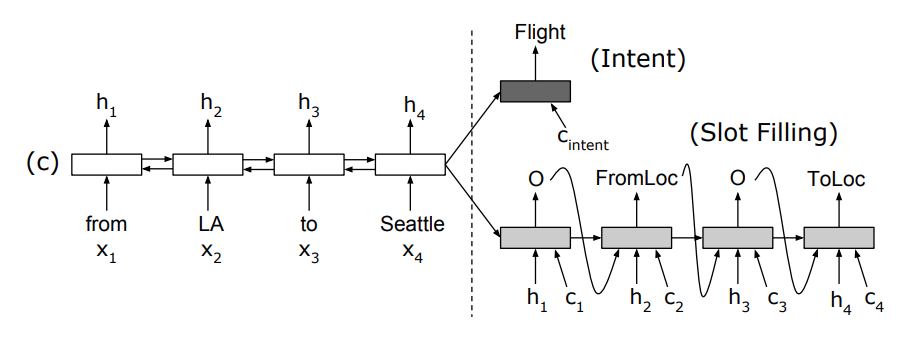

In [1]:
# Aims to understand Spoken language understanding paper by Bing Liu
# https://arxiv.org/abs/1609.01454
# Title : Attention-Based Recurrent Neural Network Models for Joint Intent Detection and Slot Filling
# I picked (c) Encoder-Decoder Model with Aligned Inputs
# Further works to implement 3.2 Attention-Based RNN Model
from IPython.display import Image
Image("picture.png")

# Data Preprocessing
Most of data preprocessing steps & basic seq2seq architecture (indexing, instantiating to class) I followed below pytorch tutorial and official chatbot tutorial
https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb
https://pytorch.org/tutorials/beginner/chatbot_tutorial.html#sphx-glr-download-beginner-chatbot-tutorial-py

In [2]:
USE_CUDA = False


In [3]:
import collections
import torch
from torch.jit import script, trace
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
device = torch.device("cuda" if USE_CUDA else "cpu")
slots_name = "data/train/train.seq.out"
intent_name = "data/train/train.labels"
utter_name = "data/train/train.in"

_DIGIT_RE = re.compile(r"\d")
def unicode_to_ascii(s):
    return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn')

def normalize_string(s):
    # digit regular expression compiler
    _DIGIT = "DIG"
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(_DIGIT_RE, _DIGIT, s)
    # below two are not necessary
#     s = re.sub(r"([.!?])", r" \1", s)
#     s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s
    
def read_langs(utters, intents, slots):
    utters_ = open(utters)
    intents_ = open(intents)
    slots_ = open(slots)
    
    utters_ = [normalize_string(line).split() for line in utters_]
    intents_ = [normalize_string(line) for line in intents_]
    slots_ = [normalize_string(line).split() for line in slots_]
    print("Number of lines : utters - {}, intent - {}, slots - {}".format(len(utters_), len(intents_), len(slots_)))
    return utters_, intents_, slots_
    
    
def loading_data(utters, intents, slots):
    input_utter, intent_labels, slot_labels = read_langs(utters, intents, slots)
    
    return input_utter, slot_labels, intent_labels

input_utter, slot_labels, intent_labels = loading_data(utter_name, intent_name, slots_name)

Number of lines : utters - 4978, intent - 4978, slots - 4978


In [4]:
# default word tokens 
# PAD token is used to put different length of sequence into mini batch
# SOS token is to mark as start of sentence
# EOS token is to mark end of sentence
PAD_token = 0
SOS_token = 1
EOS_token = 2
UNK_token = 3

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2count = collections.Counter()
        self.word2index = { "PAD" : PAD_token, "SOS":SOS_token, "EOS":EOS_token, "UNK":UNK_token}
        self.index2word = { PAD_token : "PAD", SOS_token:"SOS", EOS_token: "EOS" }
        
        self.slot2index = { "PAD" : PAD_token, "SOS":SOS_token, "EOS":EOS_token, "UNK":UNK_token}
        self.index2slot = { PAD_token : "PAD", SOS_token:"SOS", EOS_token: "EOS", UNK_token:"UNK"}
        
        self.intent2index = { "UNK" : PAD_token }
        self.index2intent = { }
        self.num_words = len(self.index2word)
    
    def addCorpus(self, sentence, slots, intents):
        
        for words, slots, intent in zip(sentence, slots, intents):
            self.addWord(words)
            self.addSlots(slots)
            if intent not in self.intent2index:
                self.intent2index[intent]= len(self.intent2index)
        for key, val in self.intent2index.items():
            self.index2intent[val] = key
                
        
    def addWord(self, words):
        for word in words:
            if word not in self.word2index:
                self.word2index[word] = self.num_words
                self.index2word[self.num_words] = word
                self.num_words += 1
            self.word2count[word] += 1
    
    def addSlots(self, slots):
        for slot in slots:
            if slot not in self.slot2index:
                self.slot2index[slot] = len(self.slot2index)
                self.index2slot[len(self.index2slot)] = slot
                
                
    def trim(self):
        MINCOUNT = 1
        self.word2index = { "PAD" : PAD_token, "SOS" : SOS_token, "EOS" : EOS_token, "UNK" : UNK_token}
        self.index2word = { PAD_token : "PAD", SOS_token:"SOS", EOS_token: "EOS",  UNK_token : "UNK"}
        self.num_words = 3
        for word, count in self.word2count.items():
            if count > MINCOUNT:
                self.word2index[word] = self.num_words
                self.index2word[self.num_words] = word
                self.num_words += 1
            

In [5]:
voc = Voc("corpus")
voc.addCorpus(input_utter, slot_labels, intent_labels)

In [6]:
#### Before trim words by minimum word count ####
len(voc.word2index), len(voc.slot2index), len(voc.intent2index)
voc.intent2index
print(voc.index2intent, len(voc.index2intent))
print(voc.intent2index, len(voc.intent2index))

{0: 'UNK', 1: 'flight', 2: 'flight_time', 3: 'airfare', 4: 'aircraft', 5: 'ground_service', 6: 'airport', 7: 'airline', 8: 'distance', 9: 'abbreviation', 10: 'ground_fare', 11: 'quantity', 12: 'city', 13: 'flight_no', 14: 'capacity', 15: 'meal', 16: 'restriction', 17: 'cheapest'} 18
{'UNK': 0, 'flight': 1, 'flight_time': 2, 'airfare': 3, 'aircraft': 4, 'ground_service': 5, 'airport': 6, 'airline': 7, 'distance': 8, 'abbreviation': 9, 'ground_fare': 10, 'quantity': 11, 'city': 12, 'flight_no': 13, 'capacity': 14, 'meal': 15, 'restriction': 16, 'cheapest': 17} 18


In [7]:
voc.trim()

In [8]:
#### After trim words by minimum word count ####
len(voc.word2index), len(voc.slot2index), len(voc.intent2index)

(578, 125, 18)

# Prepare data for models
Current variable and class information
#### input_utter : list that stores all utterance corpus
#### slot_labels : list that stores all slot corpus
#### intent_labels : lis that stores all intent informaiton for each utterance
#### voc : holds index information for token, slot and intent

## Below texts are quoted from below tutorial, but I'm writing to help myself understand better
https://pytorch.org/tutorials/beginner/chatbot_tutorial.html#sphx-glr-download-beginner-chatbot-tutorial-py


In order for our data to feed them into Tensor, we need to convert them into numerical torch tensors as inputs

In order for us to accomodate mini-batch, we will keep [max_length, batch_size] as a shape

Hence, any sentence that is shorter than max_length will have "PAD_TOKEN" after an "EOS_token"

For example : ["How", "are", "you", "EOS", "PAD", "PAD", "PAD"] max_length : 7
In the below ATIS data, maximum length is 46. Hence, we will setup maximum length as 50

In [9]:
maxlen = 0
for utter in input_utter:
    maxlen = max(maxlen, len(utter))
    if len(utter) == 46:
        print(utter)

['i', 'want', 'to', 'travel', 'from', 'kansas', 'city', 'to', 'chicago', 'round', 'trip', 'leaving', 'wednesday', 'june', 'sixteenth', 'arriving', 'in', 'chicago', 'at', 'around', 'DIG', "o'clock", 'in', 'the', 'evening', 'and', 'returning', 'the', 'next', 'day', 'arriving', 'in', 'kansas', 'city', 'at', 'around', 'DIG', "o'clock", 'in', 'the', 'evening', 'which', 'airlines', 'fly', 'that', 'route']


In [10]:
maxlen = 50
#### paring all training data and labels in pairs ####
pairs = list(zip(input_utter, slot_labels, intent_labels))
# Note : Python random.choice assumes uniform distribution by default
random.choice(pairs)
def indexesFromSentence(voc, sentence):
    return [voc.word2index.get(word, voc.word2index["UNK"]) for word in sentence] + [EOS_token]

def indexesFromSlots(voc, slots):
    return [voc.slot2index.get(slot, voc.slot2index["UNK"]) for slot in slots]+ [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue = fillvalue))

def binaryMatrix(l, value = PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    ### Convert to variable
    padVar = torch.LongTensor(padList)
    return padVar, lengths
    
def outputVar(l, voc):
    indexes_batch = [indexesFromSlots(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    ### Convert to variable
    padVar= torch.LongTensor(padList)
    return padVar, mask, max_target_len

def intentVar(l, voc):
    indexes_batch = [voc.intent2index.get(intent, voc.intent2index["UNK"]) for intent in l]
    intentVar = torch.LongTensor(indexes_batch)
    return intentVar
    
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key = lambda x : len(x[0]), reverse = True)
    input_batch, output_batch, intent_batch = [], [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
        intent_batch.append(pair[2])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    intent = intentVar(intent_batch, voc)
    return inp, lengths, output, mask, max_target_len, intent

small_batch_size = 3
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len, intent_variable = batches
print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)
print("intent variable:", intent_variable)
    

input_variable: tensor([[ 19,  57, 187],
        [ 27,  58,  14],
        [ 17,  61, 109],
        [383,  20, 110],
        [158,   7,   2],
        [108,  30,   0],
        [147,  31,   0],
        [116,   5,   0],
        [136, 109,   0],
        [125, 110,   0],
        [  8, 217,   0],
        [ 12,   2,   0],
        [ 30,   0,   0],
        [ 31,   0,   0],
        [  2,   0,   0]])
lengths: tensor([15, 12,  5])
target_variable: tensor([[ 4,  4,  4],
        [ 4,  4,  4],
        [ 4,  4, 23],
        [16,  4, 59],
        [47,  4,  2],
        [ 4,  5,  0],
        [ 4, 15,  0],
        [30,  4,  0],
        [ 4,  8,  0],
        [ 4, 22,  0],
        [ 5, 58,  0],
        [ 4,  2,  0],
        [ 8,  0,  0],
        [22,  0,  0],
        [ 2,  0,  0]])
mask: tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 0],
        [1, 1, 0],
        [1, 1, 0],
        [1, 1, 0],
        [1, 1, 0],
        [1, 1, 0],
        [1, 1, 

In [11]:
test_slots_name = "data/test/test.seq.out"
test_intent_name = "data/test/test.labels"
test_utter_name = "data/test/test.in"

test_input_utter, test_slot_labels, test_intent_labels = loading_data(test_utter_name, test_intent_name, test_slots_name)


Number of lines : utters - 893, intent - 893, slots - 893


# Encoder
Unlike original paper ( Takes only last state of backward LSTM for intent classification), I took __mean pooling over LSTM output__

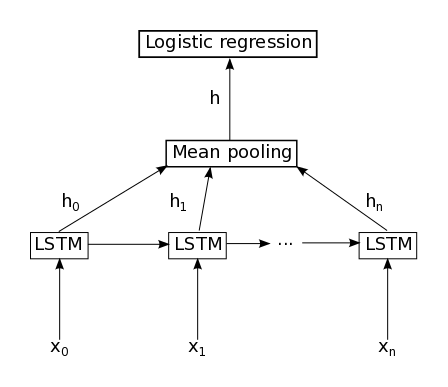

In [12]:
# Example of above description is as below
# Picture from : http://deeplearning.net/tutorial/lstm.html
Image("lstm.png")

In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, embedding, output_size, n_layers, dropout):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding
#         # @parameter information
#         # input_size : word_embedding dimension
#         # hidden_size : hidden state feature size
#         # embedding : word embedding
#         # n_layers : number of layers
#         # dropout : dropout rate
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers,
                    dropout = dropout, bidirectional = True)
        self.intent_decoder = nn.Linear(hidden_size*2, output_size, bias=True)
        
    def forward(self, input_seq, input_lengths, hidden = None):
        # Convert word indexes into embeddings
        # embedded : [seq_len, batch, embedding_dim]
        embedded = self.embedding(input_seq)
        
        # Pack padded batch of sequence for RNN module
        # packed : [batch*seq_len, embedding_dim]
        # For more detail
        # https://github.com/HarshTrivedi/packing-unpacking-pytorch-minimal-tutorial
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        # outputs : [batch_sum_seq_len, hidden_dim * num_direction (bi or uni)]
        # hidden : [num_layer * num_direction(bi), batch, hidden_sizegru]
        outputs, (hidden, memory) = self.lstm(packed, hidden)
        # Unpack padding -> zero padding packed sequence
        # outputs : #[max_seq, batch, hidden_dim * direction]
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # not sum, concatenate
        #outputs = outputs[:, :, :self.hidden_size] + outputs[:,:,self.hidden_size:]
        mean_pooling = torch.sum(outputs, dim=0) / Variable(input_lengths.type(torch.FloatTensor).view(-1,1))
        #outputs = outputs[:, :, :self.hidden_size] + outputs[:,:,self.hidden_size:]
        intent_score = self.intent_decoder(mean_pooling)

        intent_output = F.softmax(intent_score, dim = 1)
        return outputs, (hidden, memory), intent_output

# Decoder
Notation descriptions



Note : decoder takes __explicit input alignment__ of encoder's hidden state and context vector as inputs together with previous eimtted decoder output 

The author does employ teacher forcing, decoder only takes emitted output as a next input

\begin{align}
s_0 : tanh(W_s * h_1^←) \\
Eq.(5) :
Context vector : c_i & = \sum_{j=1}^T \alpha_{i,j}* h_j\\
Eq. (6) :
\alpha_{i,j} & = \frac{exp(e_{i,j})}{\sum_{k=1}^T exp(e_{i,k}) 
}\\
e_{i,k} & = g(s_{i-1}, h_k)
\end{align}


In [50]:
class InputAlignedDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers, dropout):
        super(InputAlignedDecoderRNN, self).__init__()
        
        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        # Define layers
        self.embedding = embedding
        self.LSTM = nn.LSTM(hidden_size*5, hidden_size, n_layers, dropout = dropout)
        self.g = nn.Linear(hidden_size*3, 1)
#         self.concat = nn.Linear(hidden_size * 3, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
#         self.attn = Attn(attn_model, hidden_size)
        
    def masked_softmax(self, vec, mask, dim=1, epsilon=1e-5):
        # This implementation trick from 
        # https://discuss.pytorch.org/t/apply-mask-softmax/14212/14
        exps = torch.exp(vec)
        masked_exps = exps * mask.float()
        masked_sums = masked_exps.sum(dim, keepdim = True) + epsilon
#         if torch.sum((masked_exps/masked_sums)[0]).data.numpy() < 0.99:
#             print(vec.shape, mask.shape, masked_exps.shape, torch.sum((masked_exps/masked_sums)[0]), (masked_exps/masked_sums)[0])
        return (masked_exps/masked_sums)
        
    def forward(self, input_step, last_hidden, last_memory, encoder_outputs, mask, encoder_alignment):
        # Note : we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        
        ############## Refer to above mark down equation ##############
        last_hidden_expansion = last_hidden.repeat(encoder_outputs.shape[0], 1, 1)
        # Eq (6) above
        score = torch.cat((last_hidden_expansion, encoder_outputs), 2)
        # max_len, batch
        e_ik = self.g(score).squeeze(-1).t()
        attn_energies = self.masked_softmax(e_ik, mask.t()).unsqueeze(1)
        # Eq (5) above
        context = attn_energies.bmm(encoder_outputs.transpose(0, 1)).transpose(0,1)
        
        ###### Input alignment
        encoder_alignment = encoder_alignment.unsqueeze(0)
        input_alignment = torch.cat((embedded, encoder_alignment, context), 2)
        # Forward through undirectional LSTM
        rnn_output, (hidden, memory) = self.LSTM(input_alignment, [last_hidden, last_memory])
        
        ############# This part is Luong Attention mechanism #############
        # Calculate attention weights from the current GRU output
        # attn_weights = self.attn(rnn_output, encoder_outputs, mask)
        
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        # encoder_outputs [max_len, batch, hidden_dim] -> transpose encoder_outputs [batch, max_len, hidden_dim]
        # attn_weights [batch_size, 1, max_len]
        # context : [batch_size, 1, hidden_dim] weighted sum over length
        # context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        # h˜t = tanh(Wc[ct;ht]), self.concat : Wc
        # squeeze to remove dimension 1
        # rnn_output : [seq_len = 1, batch_size, hidden_dim]rnn_output.squeeze(0) -> [batch_size, hidden_dim]
        # context.squeeze(0) -> [batch_size, attn_hidden_dim]
        
        rnn_output = rnn_output.squeeze(0)
#         context = context.squeeze(1)
#         concat_input = torch.cat((rnn_output, context), 1)
#         concat_output = torch.tanh(self.concat(concat_input))
        output = self.out(rnn_output)
        output = F.softmax(output, dim = 1)
        return output, hidden, memory, attn_energies.squeeze(1).squeeze(0)

In [51]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()
criterion = nn.CrossEntropyLoss()
def classificationLoss(inp, target):
    loss = criterion(inp, target.to(device))
    return loss.to(device)

In [55]:
def train(input_variable, lengths, target_variable, mask, max_target_len, intent_variable, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, (encoder_hidden, encoder_memory), intent_output = encoder(input_variable, lengths)
    loss = classificationLoss(intent_output, intent_variable)
    print_losses.append(loss.item())
    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    # We use backward encoder memory as initial hidden state
    decoder_hidden = encoder_hidden[1].unsqueeze(0)
    decoder_memory = encoder_memory[1].unsqueeze(0)
    attns_ = []
    for t in range(max_target_len):
        decoder_output, decoder_hidden, decoder_memory, att = decoder(
                decoder_input, decoder_hidden, decoder_memory, encoder_outputs, mask, encoder_outputs[t]
        )
            # No teacher forcing: next input is decoder's own current output
        _, topi = decoder_output.topk(1)
        decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
        decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
        mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
        loss += mask_loss
        print_losses.append(mask_loss.item() * nTotal)
        n_totals += nTotal
        
        attns_.append([sum(att[0]), att[0]])
        
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
#     print(loss)
    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return sum(print_losses) / (n_totals + 0.0005), attns_


def trainIters(voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, n_iteration, batch_size, print_every, save_every, clip):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len, intent_variable = training_batch

        # Run a training iteration with batch
        loss, attns = train(input_variable, lengths, target_variable, mask, max_target_len, intent_variable, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss
        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0
            print(attns)

            
attn_model = 'general'
embedding_size = 128
hidden_size = 128
encoder_n_layers = 1
decoder_n_layers = 1
dropout = 0.5
batch_size = 128

embedding = nn.Embedding(voc.num_words, hidden_size)
encoder = EncoderRNN(embedding_size, hidden_size, embedding, len(voc.intent2index), encoder_n_layers, dropout)
decoder = InputAlignedDecoderRNN(attn_model, embedding, hidden_size, len(voc.slot2index), decoder_n_layers, dropout)

clip = 5.0
teacher_forcing_ratio = 1.0
learning_rate = 0.001
decoder_learning_ratio = 1.0
n_iteration = 10000
# n_iteration = 1
print_every = 1000
save_every = 500

encoder.train()
decoder.train()

print('Building optimizer . . .')

encoder_optimizer = optim.Adam(encoder.parameters(), lr = learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr = learning_rate * decoder_learning_ratio)

trainIters(voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, n_iteration, batch_size,
          print_every, save_every, clip)

Building optimizer . . .
Initializing ...
Training...
Iteration: 1000; Percent complete: 10.0%; Average loss: 0.2165
[[tensor(1.0000, grad_fn=<ThAddBackward>), tensor([0.0023, 0.0047, 0.0417, 0.0269, 0.1043, 0.0248, 0.1761, 0.0233, 0.0654,
        0.0136, 0.0233, 0.0095, 0.0126, 0.0284, 0.0281, 0.0237, 0.1715, 0.0236,
        0.0710, 0.0314, 0.0153, 0.0124, 0.0101, 0.0121, 0.0439],
       grad_fn=<SelectBackward>)], [tensor(1.0000, grad_fn=<ThAddBackward>), tensor([0.0023, 0.0047, 0.0417, 0.0269, 0.1043, 0.0248, 0.1761, 0.0233, 0.0654,
        0.0136, 0.0233, 0.0095, 0.0126, 0.0284, 0.0281, 0.0237, 0.1715, 0.0236,
        0.0710, 0.0314, 0.0153, 0.0124, 0.0101, 0.0121, 0.0439],
       grad_fn=<SelectBackward>)], [tensor(1.0000, grad_fn=<ThAddBackward>), tensor([0.0023, 0.0047, 0.0417, 0.0269, 0.1043, 0.0248, 0.1761, 0.0233, 0.0654,
        0.0136, 0.0233, 0.0095, 0.0126, 0.0284, 0.0281, 0.0237, 0.1715, 0.0236,
        0.0710, 0.0314, 0.0153, 0.0124, 0.0101, 0.0121, 0.0439],
       grad

Iteration: 3000; Percent complete: 30.0%; Average loss: 0.0019
[[tensor(1.0000, grad_fn=<ThAddBackward>), tensor([0.0062, 0.0058, 0.0046, 0.0109, 0.0134, 0.1435, 0.0161, 0.1218, 0.1479,
        0.0062, 0.0790, 0.0850, 0.0088, 0.0387, 0.1112, 0.0487, 0.0190, 0.0043,
        0.0022, 0.0012, 0.0039, 0.0014, 0.0043, 0.0142, 0.0077, 0.0133, 0.0036,
        0.0078, 0.0035, 0.0021, 0.0183, 0.0254, 0.0203],
       grad_fn=<SelectBackward>)], [tensor(1., grad_fn=<ThAddBackward>), tensor([0.0062, 0.0058, 0.0046, 0.0109, 0.0134, 0.1435, 0.0161, 0.1218, 0.1479,
        0.0062, 0.0790, 0.0850, 0.0088, 0.0387, 0.1112, 0.0487, 0.0190, 0.0043,
        0.0022, 0.0012, 0.0039, 0.0014, 0.0043, 0.0142, 0.0077, 0.0133, 0.0036,
        0.0078, 0.0035, 0.0021, 0.0183, 0.0254, 0.0203],
       grad_fn=<SelectBackward>)], [tensor(1.0000, grad_fn=<ThAddBackward>), tensor([0.0062, 0.0058, 0.0046, 0.0109, 0.0134, 0.1435, 0.0161, 0.1218, 0.1479,
        0.0062, 0.0790, 0.0850, 0.0088, 0.0387, 0.1112, 0.0487, 0.0190

Iteration: 4000; Percent complete: 40.0%; Average loss: 0.0024
[[tensor(1., grad_fn=<ThAddBackward>), tensor([0.0021, 0.0018, 0.0021, 0.0020, 0.0059, 0.0066, 0.0585, 0.0117, 0.2015,
        0.1039, 0.0077, 0.0087, 0.0068, 0.0363, 0.0365, 0.1373, 0.0528, 0.0046,
        0.0201, 0.0629, 0.0364, 0.1181, 0.0443, 0.0035, 0.0210, 0.0067],
       grad_fn=<SelectBackward>)], [tensor(1.0000, grad_fn=<ThAddBackward>), tensor([0.0021, 0.0018, 0.0021, 0.0020, 0.0059, 0.0066, 0.0585, 0.0117, 0.2015,
        0.1039, 0.0077, 0.0087, 0.0068, 0.0363, 0.0365, 0.1373, 0.0528, 0.0046,
        0.0201, 0.0629, 0.0364, 0.1181, 0.0443, 0.0035, 0.0210, 0.0067],
       grad_fn=<SelectBackward>)], [tensor(1.0000, grad_fn=<ThAddBackward>), tensor([0.0021, 0.0018, 0.0021, 0.0020, 0.0059, 0.0066, 0.0585, 0.0117, 0.2015,
        0.1039, 0.0077, 0.0087, 0.0068, 0.0363, 0.0365, 0.1373, 0.0528, 0.0046,
        0.0201, 0.0629, 0.0364, 0.1181, 0.0443, 0.0035, 0.0210, 0.0067],
       grad_fn=<SelectBackward>)], [tensor(1.

Iteration: 6000; Percent complete: 60.0%; Average loss: 0.0014
[[tensor(1., grad_fn=<ThAddBackward>), tensor([0.0024, 0.0074, 0.0118, 0.0070, 0.0267, 0.2081, 0.0227, 0.3692, 0.0071,
        0.0039, 0.0096, 0.0045, 0.0106, 0.0250, 0.0009, 0.0011, 0.0010, 0.0297,
        0.0221, 0.0048, 0.0029, 0.0041, 0.0143, 0.1206, 0.0824],
       grad_fn=<SelectBackward>)], [tensor(1.0000, grad_fn=<ThAddBackward>), tensor([0.0024, 0.0074, 0.0118, 0.0070, 0.0267, 0.2081, 0.0227, 0.3692, 0.0071,
        0.0039, 0.0096, 0.0045, 0.0106, 0.0250, 0.0009, 0.0011, 0.0010, 0.0297,
        0.0221, 0.0048, 0.0029, 0.0041, 0.0143, 0.1206, 0.0824],
       grad_fn=<SelectBackward>)], [tensor(1.0000, grad_fn=<ThAddBackward>), tensor([0.0024, 0.0074, 0.0118, 0.0070, 0.0267, 0.2081, 0.0227, 0.3692, 0.0071,
        0.0039, 0.0096, 0.0045, 0.0106, 0.0250, 0.0009, 0.0011, 0.0010, 0.0297,
        0.0221, 0.0048, 0.0029, 0.0041, 0.0143, 0.1206, 0.0824],
       grad_fn=<SelectBackward>)], [tensor(1.0000, grad_fn=<ThAddBack

Iteration: 8000; Percent complete: 80.0%; Average loss: 0.0014
[[tensor(1.0000, grad_fn=<ThAddBackward>), tensor([0.0035, 0.0037, 0.0021, 0.0061, 0.1013, 0.0143, 0.1139, 0.0260, 0.0062,
        0.0518, 0.0151, 0.0038, 0.0067, 0.0026, 0.0060, 0.0815, 0.0122, 0.0934,
        0.0241, 0.0069, 0.0511, 0.0151, 0.0037, 0.0068, 0.0028, 0.0054, 0.0548,
        0.0134, 0.1016, 0.0269, 0.0090, 0.0726, 0.0223, 0.0333],
       grad_fn=<SelectBackward>)], [tensor(1.0000, grad_fn=<ThAddBackward>), tensor([0.0035, 0.0037, 0.0021, 0.0061, 0.1013, 0.0143, 0.1139, 0.0260, 0.0062,
        0.0518, 0.0151, 0.0038, 0.0067, 0.0026, 0.0060, 0.0815, 0.0122, 0.0934,
        0.0241, 0.0069, 0.0511, 0.0151, 0.0037, 0.0068, 0.0028, 0.0054, 0.0548,
        0.0134, 0.1016, 0.0269, 0.0090, 0.0726, 0.0223, 0.0333],
       grad_fn=<SelectBackward>)], [tensor(1.0000, grad_fn=<ThAddBackward>), tensor([0.0035, 0.0037, 0.0021, 0.0061, 0.1013, 0.0143, 0.1139, 0.0260, 0.0062,
        0.0518, 0.0151, 0.0038, 0.0067, 0.0026, 0.

Iteration: 9000; Percent complete: 90.0%; Average loss: 0.0013
[[tensor(1., grad_fn=<ThAddBackward>), tensor([0.0013, 0.0009, 0.0006, 0.0003, 0.0035, 0.0018, 0.0004, 0.0004, 0.0036,
        0.0004, 0.0003, 0.0047, 0.0005, 0.0008, 0.0005, 0.0009, 0.0106, 0.0174,
        0.0195, 0.0057, 0.0009, 0.0042, 0.0534, 0.0693, 0.0254, 0.2141, 0.0462,
        0.0875, 0.2481, 0.0975, 0.0447, 0.0189, 0.0158],
       grad_fn=<SelectBackward>)], [tensor(1.0000, grad_fn=<ThAddBackward>), tensor([0.0013, 0.0009, 0.0006, 0.0003, 0.0035, 0.0018, 0.0004, 0.0004, 0.0036,
        0.0004, 0.0003, 0.0047, 0.0005, 0.0008, 0.0005, 0.0009, 0.0106, 0.0174,
        0.0195, 0.0057, 0.0009, 0.0042, 0.0534, 0.0693, 0.0254, 0.2141, 0.0462,
        0.0875, 0.2481, 0.0975, 0.0447, 0.0189, 0.0158],
       grad_fn=<SelectBackward>)], [tensor(1.0000, grad_fn=<ThAddBackward>), tensor([0.0013, 0.0009, 0.0006, 0.0003, 0.0035, 0.0018, 0.0004, 0.0004, 0.0036,
        0.0004, 0.0003, 0.0047, 0.0005, 0.0008, 0.0005, 0.0009, 0.0106

Iteration: 10000; Percent complete: 100.0%; Average loss: 0.0020
[[tensor(1.0000, grad_fn=<ThAddBackward>), tensor([0.0086, 0.0059, 0.0064, 0.0137, 0.0522, 0.0062, 0.0927, 0.0449, 0.0087,
        0.0858, 0.0218, 0.0540, 0.0090, 0.0107, 0.0068, 0.0181, 0.0395, 0.0036,
        0.0474, 0.0466, 0.0076, 0.0825, 0.0243, 0.0557, 0.0094, 0.0109, 0.0060,
        0.0137, 0.0175, 0.0033, 0.0422, 0.0421, 0.0055, 0.0692, 0.0193, 0.0083],
       grad_fn=<SelectBackward>)], [tensor(1.0000, grad_fn=<ThAddBackward>), tensor([0.0086, 0.0059, 0.0064, 0.0137, 0.0522, 0.0062, 0.0927, 0.0449, 0.0087,
        0.0858, 0.0218, 0.0540, 0.0090, 0.0107, 0.0068, 0.0181, 0.0395, 0.0036,
        0.0474, 0.0466, 0.0076, 0.0825, 0.0243, 0.0557, 0.0094, 0.0109, 0.0060,
        0.0137, 0.0175, 0.0033, 0.0422, 0.0421, 0.0055, 0.0692, 0.0193, 0.0083],
       grad_fn=<SelectBackward>)], [tensor(1.0000, grad_fn=<ThAddBackward>), tensor([0.0086, 0.0059, 0.0064, 0.0137, 0.0522, 0.0062, 0.0927, 0.0449, 0.0087,
        0.0858, 

In [56]:

class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, input_seq, input_length):
        # Forward input through encoder model
        encoder_outputs, (encoder_hidden, encoder_memory), intent_output = encoder(input_seq, input_length)
        mask = torch.ones(input_seq.shape)
        # Create initial decoder input (start with SOS tokens for each sentence)
        decoder_input = torch.ones(1, 1, device = device, dtype = torch.long) * SOS_token
        
        decoder_hidden = encoder_hidden[1].unsqueeze(0)
        decoder_memory = encoder_memory[1].unsqueeze(0)
        # empty Tensor
        all_slots = torch.zeros([0], device = device, dtype = torch.long)
        attn_scores = []
        for t in range(input_seq.shape[0]):
            decoder_output, decoder_hidden, decoder_memory, attn_score = self.decoder(
                decoder_input, decoder_hidden, decoder_memory, encoder_outputs, mask, encoder_outputs[t]
            )
            decoder_scores, decoder_input = torch.max(decoder_output, dim = 1)
            all_slots = torch.cat((all_slots, decoder_input), dim = 0)
            
            decoder_input = torch.unsqueeze(decoder_input, 0)
            attn_scores.append(attn_score)
        return all_slots, attn_scores, intent_output
encoder.eval()
decoder.eval()
searcher = GreedySearchDecoder(encoder, decoder)
def evaluate():
    res = []
    attn_weights = []
    intent_res = []
    for sentence in test_input_utter:
        test_input_utter_sent = torch.LongTensor(indexesFromSentence(voc, sentence))
        test_sent_len = torch.tensor([len(sentence) + 1])
        test_input_utter_sent = test_input_utter_sent.to(device).unsqueeze(1)
        test_sent_len = test_sent_len.to(device)
        slots, attn_scores, intent_output = searcher(test_input_utter_sent, test_sent_len)
        res.append(slots)
        attn_weights.append(attn_scores)
        #print(intent_output, torch.max(intent_output), intent_output.argmax())
#         print(torch.max(intent_output, 1)[1])
#         print(intent_output.tolist()[0])
        intent_res.append(intent_output.tolist()[0])
    return res, attn_weights, intent_res


In [57]:

res, attn_weights, intent_res = evaluate()

In [58]:
import numpy as np
print(voc.index2intent)
intent_res_index = [voc.index2intent[np.argmax(intent)] for intent in intent_res]
test_slot_labels_indexes = [indexesFromSlots(voc,slots ) for slots in test_slot_labels ]

{0: 'UNK', 1: 'flight', 2: 'flight_time', 3: 'airfare', 4: 'aircraft', 5: 'ground_service', 6: 'airport', 7: 'airline', 8: 'distance', 9: 'abbreviation', 10: 'ground_fare', 11: 'quantity', 12: 'city', 13: 'flight_no', 14: 'capacity', 15: 'meal', 16: 'restriction', 17: 'cheapest'}


In [59]:
tp = 0.0
for re, tr in zip(intent_res_index, test_intent_labels):
    if re == tr:
        tp += 1.0
acc = tp/len(intent_res)
print("intent accuracy : ",acc)

from sklearn.metrics import f1_score
y_true = []
y_pred = []
for re, gold_labels in zip(res, test_slot_labels_indexes):
    re_list = re.numpy().tolist()
    if re_list[-1] == 2 and gold_labels[-1] == 2:
        re_list = re_list[:-1]
        gold_labels = gold_labels[:-1]
    if len(re_list) != len(gold_labels):
        print("Diff Len")
        break
    y_pred.extend(re_list)
    y_true.extend(gold_labels)

print("Paper benchmark result :", 95.87)
print("Slot filling weighted F1 score :", f1_score(y_true, y_pred, average='weighted'))

intent accuracy :  0.9518477043673013
Paper benchmark result : 95.87
Slot filling weighted F1 score : 0.9776072888999784


/Users/kwanghoonan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kwanghoonan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Conclusion
I could not observe a huge benefit of using context vector with attention mechanism with above equation.
Sometimes sum of context vectors was not equal to 1 ( much smaller than 1 )
Possibly my implementation design is poorly defined, but if we use well-known Global mechanism, it will be much better to observe a benefit

In [71]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib notebook

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
#     print(attentions[0].numpy()())
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


In [72]:
def squeezingTensor(tensors):
    new_tensors = []
    for tensor in tensors:
        new_tensors.append(tensor.detach().numpy())
    return new_tensors